## Plan:

* Used optimized code on mnist
* Use on real data (UCI)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm, trange

import pandas as pd
from sklearn.manifold import Isomap
np.random.seed(1234)

In [26]:
import requests, tarfile, os

Start with functions that do not need wrappers (e.g. no JIT layer) or no optimization. The variable `optim` will only ever take values in {"none", "fast", "fastest"}.

In [2]:
def pca(X, k = 30, optim = "fastest"):
    """Use PCA to project X to k dimensions."""
    
    # Center/scale the data.
    s = np.std(X, axis=0)
    s = np.where(s==0, 1, s)
    X = (X - np.mean(X, axis=0))/s

    if optim == "none":
        # Compute covariance eigenvectors with numpy.
        _, U = np.linalg.eigh(X.T@X)
        print("Custom PCA is broken; defaulting to sklearn.")
        #return X@U[:,:k]
        pca_ = PCA(n_components=k)
        return pca_.fit_transform(X)
    else:
        # Run PCA with sklearn.
        pca_ = PCA(n_components=k)
        return pca_.fit_transform(X)


def get_dists(X, optim = "fastest"):
    """Return squared Euclidean pairwise distances."""
    
    if optim == "none":
        n = X.shape[0]
        dists = np.zeros([n, n])
        
        for i in range(n):
            for j in range(i, n):
                dists[i, j] = np.sum((X[i, :] - X[j, :])**2)
 
        return dists + dists.T
    else:
        return pairwise_distances(X, metric="sqeuclidean")
    
    
def entropy(p):    
    """Calculates 2 ** H(p) of array p, where H(p) is the Shannon entropy."""
    return 2 ** np.sum(-p*np.log2(p+1e-10))
    
    
def get_Y_dists(Y, optim = "fastest"):
    """Takes in an n*n matrix Y, returns a matrix of (1+||y_i-y_j||^2)^-1."""
    D = get_dists(Y, optim = optim)
    return np.power(1 + D, -1)
    

def get_Q(Y_dists):
    """Normalize a matrix excluding the diagonal."""
    np.fill_diagonal(Y_dists, 0)
    return Y_dists/np.sum(Y_dists)

Two versions of binary search. I don't think we'll be able to do this in parallel with numba; compiling a function that takes in functions seems painful. **Can we use a different library?**

In [3]:
def binary_search_py(f, val, lb=0, ub=1e4, tol=1e-6, maxit=250):
    """Simple Python implementation of binary search."""
    
    for i in range(maxit):
        midpoint = (lb + ub)/2
        score = f(midpoint)
        
        if score < val:
            lb = midpoint
        else:
            ub = midpoint

        if np.abs(score-val) < tol:
            return midpoint 
        
    return midpoint


def binary_search_numba(f, val, lb=0, ub=1e4, tol=1e-6, maxit=250):
    """Compiled implementation of binary search.
    
    Concern: numba might explode if we try to give it a function as an argument."""
        
    return binary_search_py(f, val, lb, ub, tol, maxit)


def binary_search(f, val, lb=0, ub=1e4, tol=1e-6, maxit=250, optim = "none"):
    """
    Executes binary search to find the input x with |f(x) - val| < tol.
    
    Inputs:
        f - function to be paramterized for val
        val - desired score
        lb  - lower bound for search
        ub  - upper bound for search
        tol - tolerance
        maxit - maximum number of iterations
        optim - "none", "fast", or "fastest". Which level of optimization to run.
        
    Output:
        midpoint - value such that the score of fx is within given tolerance of val
    """
    
    if optim == "none":
        return binary_search_py(f, val, lb, ub, tol, maxit)
    else:
        return binary_search_numba(f, val, lb, ub, tol, maxit)

Two versions of the affinity function.

In [4]:
def get_pji_py(D, sigma, i):
    """Find conditional probabilities in raw Python."""

    return get_pji_numpy(D, sigma, i)


def get_pji_numpy(D, sigma, i):
    """Find conditional probabilities with broadcasting."""
    
    scale = 2*sigma**2
        
    D_scaled = -D.copy()/scale
    D_scaled -= np.max(D_scaled)
    exp_D = np.exp(D_scaled)
    exp_D[i] = 0
    
    return exp_D/np.sum(exp_D)


def get_pji(D, sigma, i, optim = "fastest"):
    """
    Compute conditional probabilities from a single row of distances..
    
    Inputs:
        D - 1xN row vector from a pairwise distance matrix D
        sigma - std of a Guassian used for conditional probabilities
        optim - "none", "fast", or "fastest". Which level of optimization to run.
        
    Output:
        pj_i - 1xN vector of conditional probabilities
    """
    
    if optim == "none":
        return get_pji_py(D, sigma, i)
    else:
        return get_pji_numpy(D, sigma, i)

Two versions to get the perplexities. This might be a giant headache to get working with numba. Maybe leave this until the end? It only runs once.

In [5]:
def get_P_py(D, perp = 30, lb = 0, ub = 1e4, tol = 1e-6, maxit = 250):
    """Optimize variances to perplexities using raw python."""
    
    N = D.shape[0]
    P = np.zeros((N,N))
    
    for i in range(N):
        f = lambda x: entropy(get_pji_py(D[i, :], sigma=x, i = i))
        sig = binary_search_py(f, val=perp, lb=lb, ub=ub, tol=tol, maxit=maxit)
        P[i, :] = get_pji_py(D[i,:], sig, i = i)
    
    return (P + P.T) / (2*N)


def get_P_numba(D, perp = 30, lb = 0, ub = 1e4, tol = 1e-6, maxit = 250):
    """
    Do the above, but with numba binary search and parallel range. To be done.
    
    CRITICAL: THIS SHOULD CALL binary_search_numba, NOT binary_search_py,
              AS WELL AS get_pji_numpy, NOT get_pji_py.
    """
    
    return get_P_py(D, perp = 30, lb = 0, ub = 1e4, tol = 1e-6, maxit = 250)


def get_P(D, perp = 30, lb = 0, ub = 1e4, tol = 1e-6, maxit = 250, optim = "fastest"):
    """
    Generates NxN symmetric affinity score matrix from pairwise distances.
    
    Input:
        D -  pairwise distance matrix.
        perp - target perplexity of conditional probabilies pj_i
        lb - lower bound in binary search 
        ub - upper bound in binary search
        tol - tolerance in binary search
        maxit - maximum  iterations in binary search
        optim - "none", "fast", or "fastest". Which level of optimization to run.
                
    Output:
        P - NxN symmetric affinity score matrix 
    """
    
    if optim == "none":
        return get_P_py(D, perp, lb, ub , tol, maxit)
    else:
        return get_P_numba(D, perp, lb, ub , tol, maxit)

Now the gradient. Concern with making this parallel: we're applying operations to rows of an array, not collecting operations to a single quantity. Might not give any speedup. 

**Update: using njit with parallel was 3x slower. Changing it to jit is now slightly faster.**

In [6]:
def grad_py(R, Y_dists, Y):
    """Compute the t-SNE gradient with raw Python."""
    
    n = Y.shape[0]
    dY = np.zeros(shape = Y.shape)
    
    for i in range(n):
        for j in range(n):
            #dY[i,:] += 4*R[i,j]*(Y[i, :] - Y[j, :])*Y_dists[i, j]
            
            for k in range(Y.shape[1]):
                dY[i,k] += 4*R[i,j]*(Y[i, k] - Y[j, k])*Y_dists[i, j]

    return dY
    

def grad_numpy(R, Y_dists, Y):
    """Compute the t-SNE gradient with vectorization."""
    dY = np.zeros_like(Y)

    for i in range(Y.shape[0]):
        # Write the sum as a dot product of a vector and a matrix.
        dY[i,:] = 4*np.dot(R[i,:]*Y_dists[i,:], Y[i,:] - Y)
            
    return dY
    

@njit(parallel=True)
def grad_numba(R, Y_dists, Y):
    """Compute the t-SNE gradient in parallel."""
    
    n = Y.shape[0]
    d = Y.shape[1]
    dY = np.zeros(shape = Y.shape)
    
    for i in prange(n):
        for j in range(n):
            for k in prange(d):
                dY[i,k] += 4*R[i,j]*(Y[i, k] - Y[j, k])*Y_dists[i, j]

    return dY



def get_grad(R, Y_dists, Y, optim = "fast"):
    """Compute the t-SNE gradient.
    
    Inputs:
        R - n*n matrix of difference between high/low dimensional affinities.
        Y_dists - n*n matrix of embedded similarities.
        optim - "none", "fast", or "fastest". Which level of optimization to run.

    Outputs:
        dY - n*d matrix of t-SNE gradients."""
    
    if optim == "none":
        return grad_py(R, Y_dists, Y)
    elif optim == "fast":
        return grad_numpy(R, Y_dists, Y)
    else:
        return grad_numba(R, Y_dists, Y)

Some learning rates.

In [7]:
def constant(t, eta_init, last_eta, c = 100):
    """Constant learning rate."""
    return c


def time_based(t, eta_init, last_eta, d = 0.01):
    """Time-based learning rate with decay d."""
    return last_eta/(1+d*t)


def step_based(t, eta_init, last_eta, d = 0.01, r = 50):
    """Step-based learning rate with decay d and rate r."""
    return eta_init*d**np.floor((1+t)/r)


def exponential(t, eta_init, last_eta, d = 0.01):
    """Exponential  learning rate with decay d."""
    return eta_init*np.exp(-d*t)

Compile the C stuff before we start benchmarking.

In [8]:
P_test = np.array([[1,2,3],
             [4,5,6],
             [7,8,9]])

Q_test = np.array([[9,7,8],
             [3,1,2],
             [6,5,4]])

Y_test = np.array([[-0.5, 0.25],
             [-1, 2],
             [3, -6]])

P_test = P_test + P_test.T
Q_test = Q_test + Q_test.T
R_test = P_test - Q_test
Y_dists_test = get_Y_dists(Y_test)
_ = get_grad(R_test, Y_dists_test, Y_test, optim = "fastest")

%timeit get_grad(R_test, Y_dists_test, Y_test, optim = "none")
%timeit get_grad(R_test, Y_dists_test, Y_test, optim = "fast")
%timeit get_grad(R_test, Y_dists_test, Y_test, optim = "fastest")

58.8 µs ± 965 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
21.7 µs ± 619 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
14.5 µs ± 2.66 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Finally, t-SNE.

In [9]:
def tsne(X, niter = 1000, alpha_init = 0.5, alpha_final = 0.8, alpha_thr = 250, 
         eta_init = 100, lr_fun = constant, d = 2, exg = 4, exg_thr = 50, 
         perplexity = 30, pca_dims = 30, optim = "fast", verbose = True):
    """Run t-SNE.
    
    Required inputs: 
        X - NxM matrix
    
    Optional inputs:
        d - dimension of embedding
        perplexity - target perplexity
        niter - number of iterations
        alpha_int - initial value of momentum
        alpha_final - final value of momentum term
        alpha_thr - iteration when momentum changes
        eta_init - initial learning rate
        lr_fun - learning rate function
        exg - multiplicative factor for early exaggeration
        exg_thr - iteration to stop exaggeration
        pca_dims - maximum number of dimensions before preprocessing with PCA
        optim - "none", "fast", or "fastest". Which level of optimization to run
        verbose - bool, whether or not to print a progress bar
    
    Outputs:
        Y - (niter + 2) x N x d array of embeddings for each iteration"""
    
    #
    #
    # TO do - sanitize inputs.
    #
    #
    
    if X.shape[1] > pca_dims:
        # Reduce dimension if needed.
        X = pca(X, pca_dims, optim)
    
    # Get affinities with exaggeration.
    D = get_dists(X, optim)    
    pij = exg*get_P(D, perplexity, optim)
    
    # Initialize first few iterations.
    size = (pij.shape[0], d)
    Y = np.zeros(shape = (niter + 2, size[0], d))
    initial_vals = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y[0, :, :] = Y_m1 = Y[1, :, :] = Y_m2 = initial_vals
    
    last_eta = eta_init
    alpha = alpha_init
    
    if verbose:
        #
        # Look at disable in trange
        # remove verbose stuff
        #
        iterator = trange(2, niter + 2)
    else:
        iterator = range(2, niter + 2)
    
    for i in iterator:
        if i == int(alpha_thr):
            # Reduce momentum after some time.
            alpha = alpha_final
        
        if i == int(exg_thr):
            # Stop the exaggeration.
            pij /= exg
        
        # Compute gradient.
        Y_dists = get_Y_dists(Y_m1, optim)
        qij = get_Q(Y_dists)
        rij = pij - qij
        grad = get_grad(rij, Y_dists, Y_m1, optim)
        
        # Update learning rate.
        eta = lr_fun(i, eta_init, last_eta)
        last_eta = eta
        
        # Update embeddings.
        Y_new = Y_m1 - eta*grad + alpha*(Y_m1 - Y_m2)
        Y_m2, Y_m1 = Y_m1, Y_new
        Y[i, :, :] = Y_new
    
    return Y

Current `optim="none"` takes ~5 minutes with 100 iterations.

## MNIST Data Visualization

In [39]:
# https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
def get_uci(save_folder="./data/",  chunk_size=128):
    """Retreives gene expression data from UCI ML repository"""
    
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz"
    save_path = os.path.join(save_folder, "TCGA-PANCAN-HiSeq-801x20531.tar.gz")
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as f:
        print(f"Retrieving RNA-Seq (HiSeq) PANCAN data set from {url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote tarfile to {save_path}\n")
    
    with tarfile.open(save_path) as f:
        dest = os.path.join(save_folder, "TCGA-PANCAN-HiSeq")
        print(f"Extracting tarfile to {dest}\n")
        f.extractall(dest)
        
    
def get_humanM1_10x(data_folder="./data",  chunk_size=128):
    """Retreives gene expression data on single-nucleus transcriptomes from 2 post-mortem human brain specimen.
       The data were generated as part of a BICCN collaboration to characterize cell type diversity in M1 
       across species and data modalities. 
       
       Saves data within a folder called humanM1_10x.
       
       
       Required inputs: 
           data_folder - path to location where humanM1_10x is saved
    
       Optional inputs:
           chunk_size ~ sample size 
    
    """
    
    folder_path = os.path.join(data_folder, "humanM1_10x")
    
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    
    gene_url = "https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv"
    meta_url = "https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/metadata.csv"
    
    save_path = os.path.join(folder_path, "matrix.csv")
    r = requests.get(gene_url, stream=True)
    with open(save_path, 'wb') as f:
        print(f"Retrieving gene expression data set from {gene_url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote gene expression data to {save_path}\n")
    
    
    
    
    save_path = os.path.join(folder_path, "metadata.csv")
    r = requests.get(meta_url, stream=True)
    with open(save_path, 'wb') as f:
        print(f"Retrieving meta data for gene expression matrix from {gene_url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote meta data to {save_path}\n")

In [15]:
def load_mnist(folderpath='./', size=None):
    """Loads mnist datmjkj
    
    Required inputs: 
        folderpath - to folder with mnist data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ pixel data for mnist dat
        Y - digit labels correponding to 
    
    """
    
    data_path = os.path.join(folderpath, 'X_MNIST.npy')
    label_path = os.path.join(folderpath, 'y_MNIST.npy')
    X = np.load(data_path)
    Y = np.load(label_path)
    
    if isinstance(size, int):
        index = np.random.choice(np.arange(y.size), size=size)
        
        return X[index, :], Y[index]
        
    
    return X,Y

In [16]:
def load_UCI(folderpath='./', size=None):
    """Loads mnist datmjkj
    
    Required inputs: 
        folderpath - to folder with UCI RNA gene expression data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ gene expressions
        Y - type of tumor
    
    """
    
    data_path = os.path.join(folderpath, 'data.csv')
    label_path = os.path.join(folderpath, 'labels.csv')
    
    X = pd.read_csv(data_path)
    Y = pd.read_csv(label_path)
    
#     X = np.genfromtxt(data_path, delimiter=',',skip_header=1)
#     Y = np.genfromtxt(label_path, delimiter=',',skip_header=1)
    
    if isinstance(size, int):
        index = np.random.choice(np.arange(y.size), size=size)
        
        return X[index, :], Y[index]
        
    
    return X,Y

In [60]:
def load_humanM1(folderpath='./data/humanM1_10x', nrows=3000):
    """Loads mnist datmjkj
    
    Required inputs: 
        folderpath - to folder with UCI RNA gene expression data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ gene expressions
        Y - type of tumor
    
    """
    
    data_path = os.path.join(folderpath, 'matrix.csv')
    label_path = os.path.join(folderpath, 'metadata.csv')
    
    data = pd.read_csv(data_path, nrows = 3000)
    meta_data = pd.read_csv(label_path)
    
    #  Extract sample ids from gene expression matrix
    labels = data[["sample_name"]]  
    
    # Merge sample ids to meta_data to get class labels 
    labels = labels.merge(meta_data, how="left", on="sample_name")
    
    return data.values[:,1:].astype(int), labels.class_label.values

In [28]:
get_uci()

Retrieving RNA-Seq (HiSeq) PANCAN data set from https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz

Wrote tarfile to ./data/TCGA-PANCAN-HiSeq-801x20531.tar.gz

Extracting tarfile to ./data/TCGA-PANCAN-HiSeq



In [40]:
get_humanM1_10x()

Retrieving gene expression data set from https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv

Wrote gene expression data to ./data/humanM1_10x/matrix.csv

Retrieving meta data for gene expression matrix from https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv

Wrote meta data to ./data/humanM1_10x/metadata.csv



In [32]:
ls data/TCGA-PANCAN-HiSeq/TCGA-PANCAN-HiSeq-801x20531

data.csv  labels.csv


In [14]:
X, Y = load_mnist(size=3000)

NameError: name 'load_mnist' is not defined

Prepping color for labels

In [48]:
c_dict = {0:'red', 
          1: 'orange',
          2: 'greenyellow',
          3: 'lime',
          4: 'mediumspringgreen',
          5: 'aqua',
          6: 'blue', 
          7:  'royalblue',
          8: 'fuchsia',
          9: 'deeppink'}

In [53]:
%%time 
X_tsne = tsne(X = X, niter = 2000, optim = "fastest")


CPU times: user 10min 47s, sys: 1min 48s, total: 12min 36s
Wall time: 10min 25s


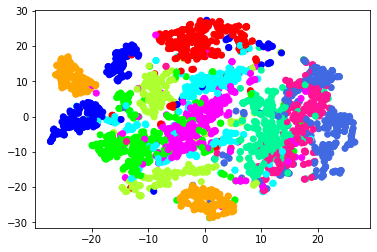

In [55]:
plt.scatter(X_tsne[-1,:,0], 
            X_tsne[-1,:,1], 
            c = np.array(list(map(lambda x: c_dict[x],
                                  Y))))
pass

In [58]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz

--2021-04-19 19:23:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72856320 (69M) [application/x-httpd-php]
Saving to: ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz’

TCGA-PANCAN-HiSeq-8 100%[===================>]  69.48M   559KB/s    in 25s     

2021-04-19 19:23:27 (2.73 MB/s) - ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz’ saved [72856320/72856320]



## UCI gene expression Data Visualization

In [83]:
X, y = load_UCI(folderpath='./TCGA-PANCAN-HiSeq-801x20531/')

In [87]:
X.columnsypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

Index(['Unnamed: 0', 'gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4',
       'gene_5', 'gene_6', 'gene_7', 'gene_8',
       ...
       'gene_20521', 'gene_20522', 'gene_20523', 'gene_20524', 'gene_20525',
       'gene_20526', 'gene_20527', 'gene_20528', 'gene_20529', 'gene_20530'],
      dtype='object', length=20532)

In [96]:
X.rename({'Unnamed: 0' : 'sample_id'}, axis=1, inplace=True)
y.rename({'Unnamed: 0' : 'sample_id'}, axis=1, inplace=True)

In [97]:
X.head()

,sample_id,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [100]:
np.all(X.sample_id == y.sample_id)

True

In [114]:
y.Class.unique()Wednsday

array(['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], dtype=object)

In [143]:
c_dict = {'PRAD':'red', 
          'LUAD': 'orange',
          'BRCA': 'royalblue',
          'KIRC': 'deeppink',
          'COAD': 'mediumspringgreen'
         }

In [137]:
genes = X.values[:, 1:].astype(float)


In [153]:
labels = y.Class.values
uniq_labs = y.Class.unique()

In [196]:
%%time 
c_tsne = tsne(X = genes, niter = 5000, optim = "fastest")


CPU times: user 1min 55s, sys: 2.17 s, total: 1min 57s
Wall time: 1min 29s


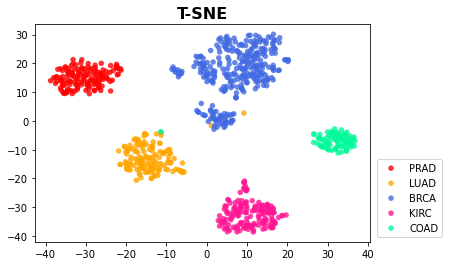

In [197]:
%matplotlib inline
fig, ax = plt.subplots()


for lab in uniq_labs:
    index = labels==lab
    d1, d2 =  c_tsne[-1,:,0][index], c_tsne[-1,:,1][index]
    ax.scatter(d1, d2, alpha=0.8, c=c_dict[lab], edgecolors='none', s=30, label=lab)
plt.legend(loc=4, bbox_to_anchor=(1.23,0))
plt.title("T-SNE", fontdict={'size':16, 'fontweight':'bold'})
pass

In [213]:
gene_PCA = pca(genes, k=2)

In [214]:
botulism in coconut milkgene_PCA.shape

(801, 2)

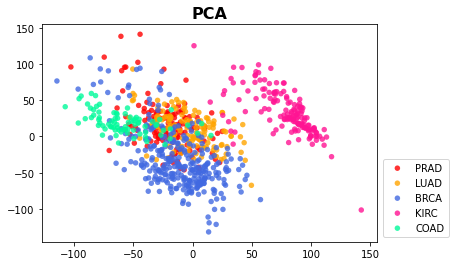

In [215]:
%matplotlib inline
fig, ax = plt.subplots()


for lab in uniq_labs:
    index = labels==lab
    d1, d2 =  gene_PCA[:,0][index], gene_PCA[:,1][index]
    ax.scatter(d1, d2, alpha=0.8, c=c_dict[lab], edgecolors='none', s=30, label=lab)
plt.legend(loc=4, bbox_to_anchor=(1.23,0))
plt.title("PCA", fontdict={'size':16, 'fontweight':'bold'})
pass

In [210]:
embedding = Isomap(n_neighbors = 20, n_components=2)

In [211]:
iso_genes = embedding.fit_transform(genes)

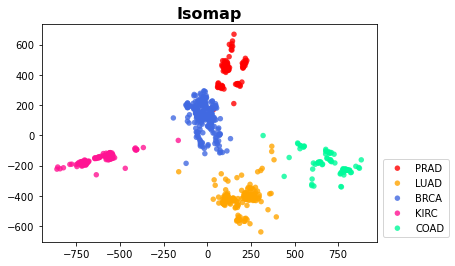

In [212]:
%matplotlib inline
fig, ax = plt.subplots()


for lab in uniq_labs:
    index = labels==lab
    d1, d2 =  iso_genes[:,0][index], iso_genes[:,1][index]
    ax.scatter(d1, d2, alpha=0.8, c=c_dict[lab], edgecolors='none', s=30, label=lab)
plt.legend(loc=4, bbox_to_anchor=(1.23,0))
plt.title("Isomap", fontdict={'size':16, 'fontweight':'bold'})
pass

####  More gene expressions

In [61]:
%%time
genes, samples = load_humanM1()

CPU times: user 1min 50s, sys: 6.61 s, total: 1min 56s
Wall time: 1min 56s


In [28]:
get_uci()

Retrieving RNA-Seq (HiSeq) PANCAN data set from https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz

Wrote tarfile to ./data/TCGA-PANCAN-HiSeq-801x20531.tar.gz

Extracting tarfile to ./data/TCGA-PANCAN-HiSeq



In [17]:
genes = pd.read_csv("/home/marc/Downloads/matrix.csv", nrows = 3000)

In [18]:
class_info = pd.read_csv("/home/marc/Downloads/metadata.csv")

In [19]:
class_info = class_info[['sample_name', 'class_label', 'class_color']]

In [20]:
samples = genes[["sample_name"]]
genesX = genes.values[:,1:].astype(int)

In [21]:
%%time 
g_tsne = tsne(X = genesX, niter = 5000, optim = "fastest")

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 1h 9min 20s, sys: 38.5 s, total: 1h 9min 58s
Wall time: 27min 19s


In [24]:
sample = samples.merge(class_info, how="left", on="sample_name")

In [25]:
sample.head()

,sample_name,class_label,class_color
0,AAACCCAAGGATTTCC-LKTX_190129_01_A01,GABAergic,#FF7373
1,AAACCCAAGTATGGCG-LKTX_190129_01_A01,Glutamatergic,#3DCC3D
2,AAACCCACAAAGTGTA-LKTX_190129_01_A01,Glutamatergic,#3DCC3D
3,AAACCCACACTACTTT-LKTX_190129_01_A01,Glutamatergic,#3DCC3D
4,AAACCCACAGTGAGCA-LKTX_190129_01_A01,Non-Neuronal,#171799


In [26]:
unq_classes = class_info[~class_info[['class_label', 'class_color']].duplicated()]

In [27]:
unq_classes

,sample_name,class_label,class_color
0,AAACCCAAGGATTTCC-LKTX_190129_01_A01,GABAergic,#FF7373
1,AAACCCAAGTATGGCG-LKTX_190129_01_A01,Glutamatergic,#3DCC3D
4,AAACCCACAGTGAGCA-LKTX_190129_01_A01,Non-Neuronal,#171799


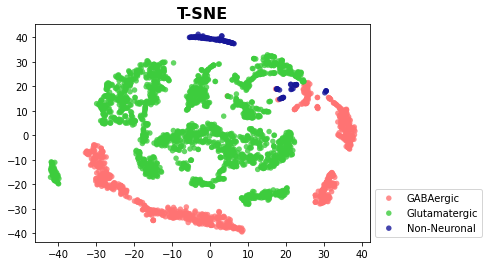

In [45]:
%matplotlib inline
fig, ax = plt.subplots()


for lab in unq_classes.class_label.values:
    index = (sample.class_label.values[:] == lab).ravel()
    color = unq_classes[unq_classes.class_label==lab]['class_color'].values[0]
    d1, d2 =  g_tsne[-1,:,0][index], g_tsne[-1,:,1][index]
    ax.scatter(d1, d2, alpha=0.8, c=color, edgecolors='none', s=30, label=lab)
plt.legend(loc=4, bbox_to_anchor=(1.35,0))
plt.title("T-SNE", fontdict={'size':16, 'fontweight':'bold'})
pass

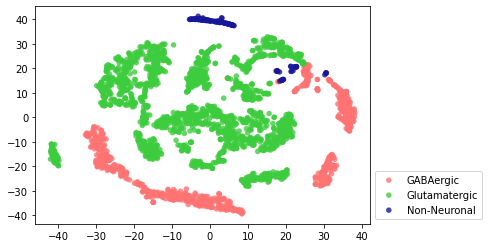

In [60]:
plot_2dclusters(g_tsne[-1,:,0], g_tsne[-1,:,1], 
                sample.class_label.values, 
                c_map=c_map, 
                title="")

In [17]:
gene_PCA = pca(genesX, k=2)

In [18]:
gene_PCA.shape

(3000, 2)

In [27]:
unq_classes[unq_classes.class_label==lab].values[0]

array(['AAACCCAAGGATTTCC-LKTX_190129_01_A01', 'GABAergic', '#FF7373'],
      dtype=object)

In [34]:
unq_classes[unq_classes.class_label==lab]['class_color'].values[0]

'#3DCC3D'

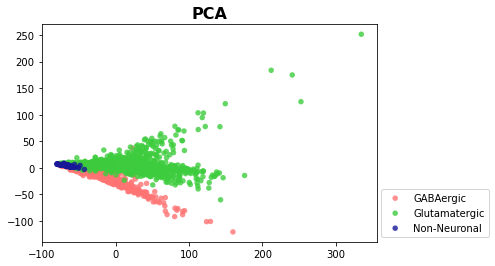

In [36]:
%matplotlib inline
fig, ax = plt.subplots()



for lab in unq_classes.class_label.values:
    index = (sample.class_label.values[:] == lab).ravel()
    color = unq_classes[unq_classes.class_label==lab]['class_color'].values[0]
    
    d1, d2 =  gene_PCA[:,0][index], gene_PCA[:,1][index]
    ax.scatter(d1, d2, alpha=0.8, c=color, edgecolors='none', s=30, label=lab)
plt.legend(loc=4, bbox_to_anchor=(1.35,0))
plt.title("PCA", fontdict={'size':16, 'fontweight':'bold'})
pass

In [40]:
del gene_PCA

In [49]:
embedding = Isomap(n_neighbors = 25, n_components=2)_190129_01_A01

In [50]:
iso_genes = embedding.fit_transform(genesX)

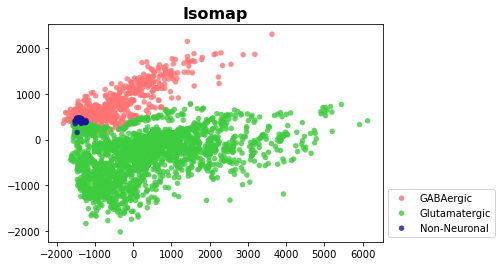

In [51]:
%matplotlib inline
fig, ax = plt.subplots()


for lab in unq_classes.class_label.values:
    index = (sample.class_label.values[:] == lab).ravel()
    color = unq_classes[unq_classes.class_label==lab]['class_color'].values[0]
    
    d1, d2 =  iso_genes[:,0][index], iso_genes[:,1][index]
    ax.scatter(d1, d2, alpha=0.8, c=color, edgecolors='none', s=30, label=lab)
plt.legend(loc=4, bbox_to_anchor=(1.35,0))
plt.title("Isomap", fontdict={'size':16, 'fontweight':'bold'})
pass